In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cpu'

In [ ]:
class Generator(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.activation = nn.ReLU()
    # Initialize weights
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)


  def forward(self,x):
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    #x = self.activation(x)
    x = torch.tanh(x)
    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.activation = nn.ReLU()
    # Initialize weights
    nn.init.xavier_uniform_(self.fc1.weight)
    nn.init.xavier_uniform_(self.fc2.weight)


  def forward(self,x):
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    #x = torch.sigmoid(x)  # Sigmoid activation for binary classification... # logits are used instead of probabilities for the discriminator's output
    return x

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and visualize sample images
def visualize_samples(generator, num_samples=25, figsize=(5, 5), image_size=(28, 28)):
    # Generate random noise vectors
    noise = torch.randn(num_samples, latent_size).to(device)

    # Generate fake images from the noise vectors
    with torch.no_grad():
        generated_images = generator(noise).cpu()

    # Convert the generated images to numpy arrays and reshape them
    generated_images = generated_images.view(num_samples, *image_size).numpy()

    # Plot the generated images in a grid
    plt.figure(figsize=figsize)
    for i in range(num_samples):
        plt.subplot(10, 5, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def train(generator, discriminator, dataloader, num_epochs, batch_size, learning_rate):
    #criterion = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss()  # Use logistic loss
    g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader):
            # Train discriminator
            discriminator.zero_grad()
            real_images, _ = data
            real_images = real_images.view(real_images.size(0), -1)
            real_images = real_images.to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train discriminator on real data
            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)
            d_loss_real.backward()

            # Train discriminator on fake data
            z = torch.randn(batch_size, latent_size)
            z = z.to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach()) # detaching so that generator's parameters are not updated based on the gradients computed during the discriminator's training on fake data
            d_loss_fake = criterion(fake_outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            d_optimizer.step()

            # Train generator
            generator.zero_grad()
            z = torch.randn(batch_size, latent_size)
            z = z.to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels) # generator wants the discriminator’s predictions to be all ones, i.e Discrimator to predict fake images as real
            g_loss.backward()
            g_optimizer.step()

            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                      f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}')

        visualize_samples(generator)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 100
#mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_data = datasets.MNIST("./", train=True, download=True, transform=transform)
data_loader = DataLoader(dataset=mnist_data, batch_size=batch_size, shuffle=True)




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6062103.34it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 155414.95it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 695551.63it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7372495.65it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



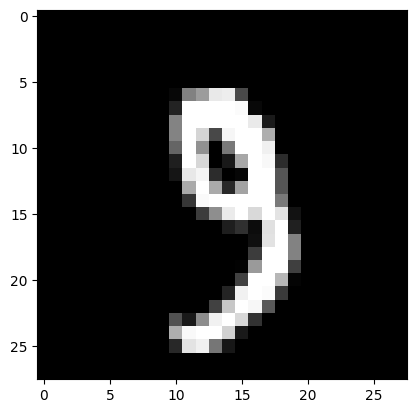

In [ ]:
def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images, labels = next(iter(data_loader))
plot_digit(images[1])

In [ ]:
# Hyperparameters
latent_size = 64
hidden_size = 256
image_size = 784  # 28x28 for MNIST

# Instantiate networks
generator = Generator(latent_size, hidden_size, image_size)
generator = generator.to(device)
discriminator = Discriminator(image_size, hidden_size, 1)
discriminator = discriminator.to(device)


In [ ]:
num_epochs = 50
learning_rate = 0.001

train(generator, discriminator, data_loader, num_epochs, batch_size, learning_rate)


Output hidden; open in https://colab.research.google.com to view.

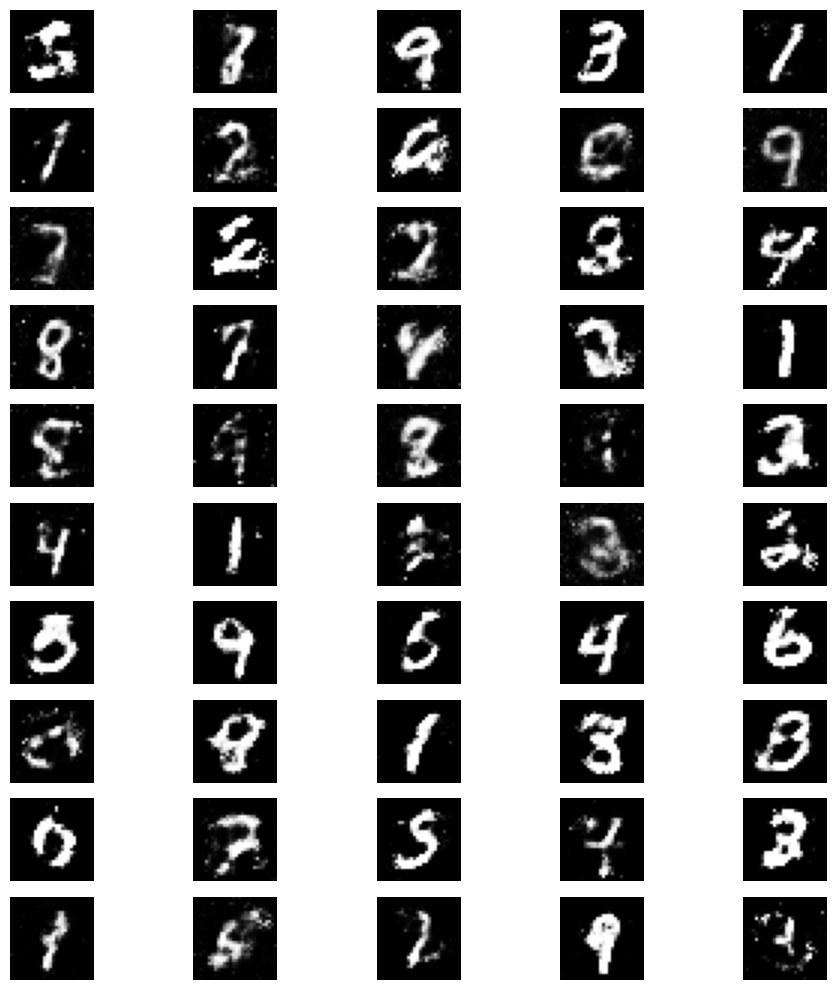

In [ ]:


# Generate and visualize sample images
visualize_samples(generator)